In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pathlib import Path

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Setup

This project requires Python 3.7 or above

In [ ]:
import sys 

assert sys.version_info >= (3, 7)

And Tensorflow >= 2.8

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Let's define the default font sizes to make the figures look prettier.

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the images/rnn folder, and define the savefig() function to save the images in high resolution.

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

RNNs can be very slow without a GPU, so let's make sure there's one, or else issue a warning.

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")

## Basic RNNs

Let's download the ridership data.

In [ ]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [ ]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day-type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) 
df = df.drop_duplicates()

In [ ]:
df.head()

,day-type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive).

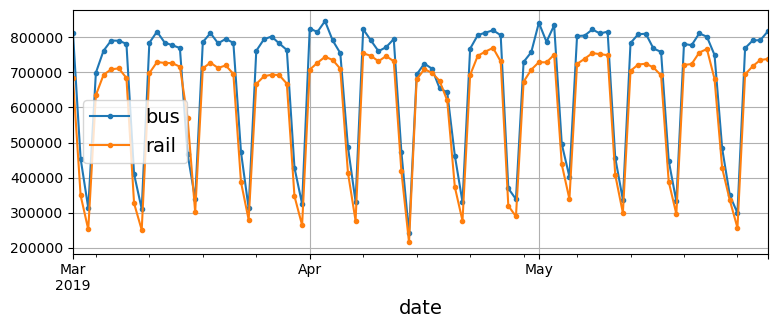

In [ ]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")
plt.show()

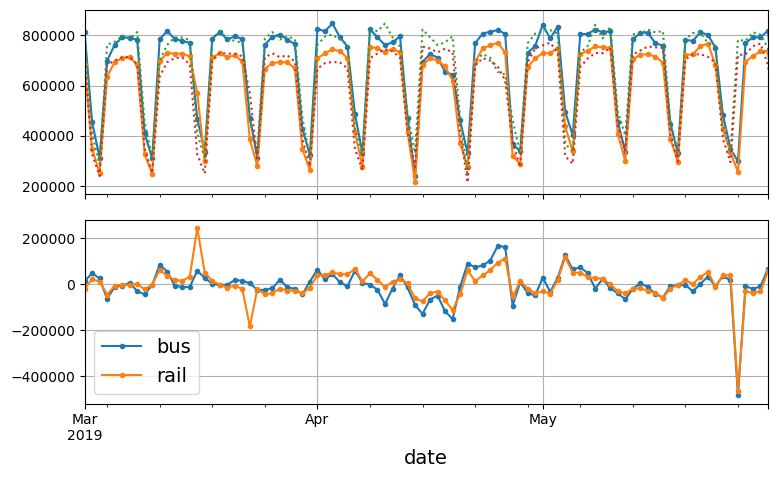

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[0].set_ylim([170_000, 900_000])
save_fig("dofferencing_plot")
plt.show()

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day-type"])

['A', 'U', 'U']

Measuring the mean absolute error over the three-month period we are arbitrarily focusing on.

In [ ]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Measuring the Mean Absolute Percentage Error

In [ ]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

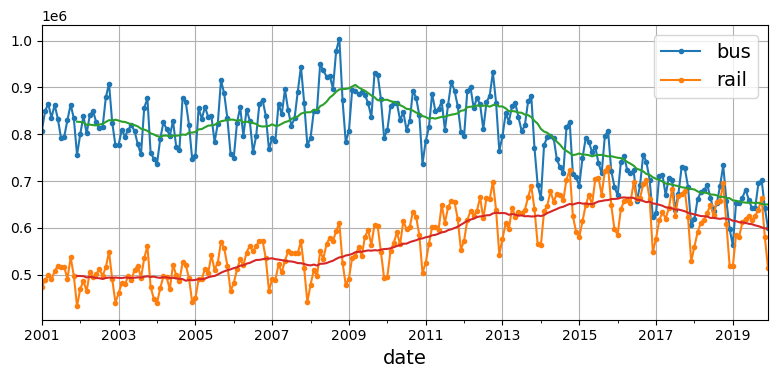

In [ ]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")
plt.show()

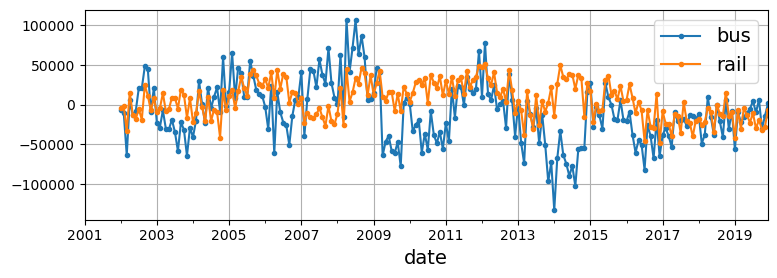

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")
plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
             order=(1, 0, 0),
             seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [ ]:
y_pred[0] # ARIMA forecase

427758.6263264185

In [ ]:
df["rail"].loc["2019-06-1"] # target value

379044

In [ ]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], # train in data up to today
                 order=(1, 0, 0),
                 seasonal_order=(0, 1, 1, 7))
    model = model.fit() # note that we retrain the model everyday
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
    
y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [ ]:
mae

32040.72010010128

In [ ]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
my_series,
targets=my_series[3:],
sequence_length=3,
batch_size=2)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [ ]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [ ]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [ ]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [ ]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [ ]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics="mae")
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 4s 21ms/step - loss: 0.0827 - mae: 0.3134 - val_loss: 0.0113 - val_mae: 0.1193
Epoch 2/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0105 - mae: 0.1158 - val_loss: 0.0106 - val_mae: 0.1150
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0086 - mae: 0.0987 - val_loss: 0.0071 - val_mae: 0.0868
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0063 - mae: 0.0838 - val_loss: 0.0072 - val_mae: 0.0891
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0058 - mae: 0.0799 - val_loss: 0.0065 - val_mae: 0.0835
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0768 - val_loss: 0.0061 - val_mae: 0.0803
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0055 - mae: 0.0782 - val_loss: 0.0059 - val_mae: 0.0781
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 0.

In [ ]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0382


38215.46584367752

## Using a Simple RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

Defining a utility function we'll reuse several time.

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, 
                       callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 46ms/step - loss: 0.0421 - mae: 0.2034 - val_loss: 0.0238 - val_mae: 0.1343
Epoch 2/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0197 - mae: 0.1696 - val_loss: 0.0193 - val_mae: 0.1368
Epoch 3/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0186 - mae: 0.1630 - val_loss: 0.0177 - val_mae: 0.1435
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0180 - mae: 0.1627 - val_loss: 0.0173 - val_mae: 0.1414
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0175 - mae: 0.1622 - val_loss: 0.0170 - val_mae: 0.1401
Epoch 6/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0171 - mae: 0.1605 - val_loss: 0.0167 - val_mae: 0.1376
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0167 - mae: 0.1598 - val_loss: 0.0164 - val_mae: 0.1365
Epoch 8/500
33/33 [==============================] - 1s 40ms/step - loss: 0.

121232.82253742218

In [ ]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 64ms/step - loss: 0.0475 - mae: 0.2194 - val_loss: 0.0045 - val_mae: 0.0774
Epoch 2/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0040 - mae: 0.0617 - val_loss: 0.0024 - val_mae: 0.0447
Epoch 3/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0033 - mae: 0.0528 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 4/500
33/33 [==============================] - 2s 50ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0029 - val_mae: 0.0474
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0030 - val_mae: 0.0548
Epoch 6/500
33/33 [==============================] - 2s 55ms/step - loss: 0.0039 - mae: 0.0624 - val_loss: 0.0031 - val_mae: 0.0518
Epoch 7/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0032 - mae: 0.0526 - val_loss: 0.0025 - val_mae: 0.0460
Epoch 8/500
33/33 [==============================] - 1s 42ms/step - loss: 0.

29804.091900587082

## Deep RNNs

In [ ]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 7s 153ms/step - loss: 0.0790 - mae: 0.2761 - val_loss: 0.0144 - val_mae: 0.1605
Epoch 2/500
33/33 [==============================] - 5s 140ms/step - loss: 0.0148 - mae: 0.1491 - val_loss: 0.0129 - val_mae: 0.1343
Epoch 3/500
33/33 [==============================] - 5s 152ms/step - loss: 0.0137 - mae: 0.1450 - val_loss: 0.0120 - val_mae: 0.1152
Epoch 4/500
33/33 [==============================] - 5s 163ms/step - loss: 0.0127 - mae: 0.1342 - val_loss: 0.0106 - val_mae: 0.1020
Epoch 5/500
33/33 [==============================] - 5s 145ms/step - loss: 0.0119 - mae: 0.1267 - val_loss: 0.0071 - val_mae: 0.0964
Epoch 6/500
33/33 [==============================] - 5s 154ms/step - loss: 0.0084 - mae: 0.1006 - val_loss: 0.0060 - val_mae: 0.0970
Epoch 7/500
33/33 [==============================] - 5s 139ms/step - loss: 0.0070 - mae: 0.0899 - val_loss: 0.0079 - val_mae: 0.1093
Epoch 8/500
33/33 [==============================] - 5s 152ms/step - 

## Multivariate time series

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day-type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
# Creating the mulvar ds
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

33/33 [==============================] - 2s 53ms/step - loss: 0.0011 - mae: 0.0325 - val_loss: 7.8309e-04 - val_mae: 0.0283
Epoch 31/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0012 - mae: 0.0344 - val_loss: 9.1662e-04 - val_mae: 0.0326
Epoch 32/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0011 - mae: 0.0318 - val_loss: 6.6309e-04 - val_mae: 0.0254
Epoch 33/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0011 - mae: 0.0329 - val_loss: 8.4971e-04 - val_mae: 0.0304
Epoch 34/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0012 - mae: 0.0346 - val_loss: 9.1743e-04 - val_mae: 0.0323
Epoch 35/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0012 - mae: 0.0333 - val_loss: 7.8398e-04 - val_mae: 0.0296
Epoch 36/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0011 - mae: 0.0317 - val_loss: 6.9605e-04 - val_mae: 0.0262
Epoch 37/500
33/33 [==============================] - 

Build and train a multitask RNN that forecasts both rail and bus

In [ ]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:], # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds, epochs=500,
                learning_rate=0.02)

33/33 [==============================] - 1s 41ms/step - loss: 0.0024 - mae: 0.0473 - val_loss: 0.0012 - val_mae: 0.0373
Epoch 7/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0023 - mae: 0.0465 - val_loss: 0.0011 - val_mae: 0.0336
Epoch 8/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0021 - mae: 0.0452 - val_loss: 0.0015 - val_mae: 0.0421
Epoch 9/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0021 - mae: 0.0449 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 10/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0021 - mae: 0.0448 - val_loss: 0.0012 - val_mae: 0.0365
Epoch 11/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0021 - mae: 0.0445 - val_loss: 0.0012 - val_mae: 0.0370
Epoch 12/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0020 - mae: 0.0443 - val_loss: 0.0011 - val_mae: 0.0350
Epoch 13/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0019 - m

25514.68275487423

In [ ]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 9ms/step
bus 26180
rail 24848


## Forecasting Several Steps Ahead

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 25ms/step


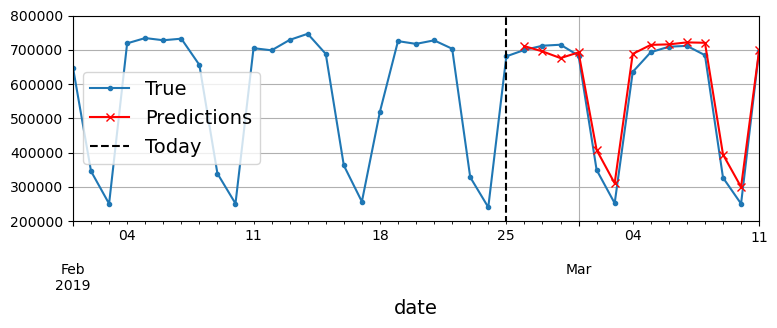

In [ ]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                  index=pd.date_range("2019-02-26", "2019-03-11"))
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [ ]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0661 - mae: 0.2714 - val_loss: 0.0233 - val_mae: 0.1660
Epoch 2/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0194 - mae: 0.1598 - val_loss: 0.0162 - val_mae: 0.1348
Epoch 3/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0155 - mae: 0.1414 - val_loss: 0.0128 - val_mae: 0.1216
Epoch 4/500
33/33 [==============================] - 2s 47ms/step - loss: 0.0132 - mae: 0.1297 - val_loss: 0.0108 - val_mae: 0.1115
Epoch 5/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0114 - mae: 0.1200 - val_loss: 0.0092 - val_mae: 0.1037
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0101 - mae: 0.1106 - val_loss: 0.0076 - val_mae: 0.0957
Epoch 7/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0090 - mae: 0.1029 - val_loss: 0.0066 - val_mae: 0.0893
Epoch 8/500
33/33 [==============================] - 1s 39ms/step - loss: 0.

34271.21788263321

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length] 
Y_pred = ahead_model.predict(X)
Y_pred.shape

1/1 [==============================] - 0s 26ms/step


(1, 14)

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use to_windows() twice, to get sequences of consecutive windows, like this:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                      batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

Create the datasets

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

And lastly, we can build the sequence-to-sequence model:

In [ ]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 4s 77ms/step - loss: 0.0854 - mae: 0.2967 - val_loss: 0.0160 - val_mae: 0.1365
Epoch 2/500
33/33 [==============================] - 2s 53ms/step - loss: 0.0117 - mae: 0.1129 - val_loss: 0.0079 - val_mae: 0.0890
Epoch 3/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0075 - mae: 0.0849 - val_loss: 0.0063 - val_mae: 0.0770
Epoch 4/500
33/33 [==============================] - 2s 51ms/step - loss: 0.0060 - mae: 0.0737 - val_loss: 0.0055 - val_mae: 0.0698
Epoch 5/500
33/33 [==============================] - 2s 51ms/step - loss: 0.0054 - mae: 0.0682 - val_loss: 0.0048 - val_mae: 0.0624
Epoch 6/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0050 - mae: 0.0654 - val_loss: 0.0049 - val_mae: 0.0644
Epoch 7/500
33/33 [==============================] - 2s 58ms/step - loss: 0.0048 - mae: 0.0640 - val_loss: 0.0046 - val_mae: 0.0618
Epoch 8/500
33/33 [==============================] - 2s 50ms/step - loss: 0.

47488.7378513813

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

1/1 [==============================] - 0s 149ms/step


In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                     index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 24ms/step
MAE for +1: 22,534
MAE for +2: 29,610
MAE for +3: 31,233
MAE for +4: 32,569
MAE for +5: 35,174
MAE for +6: 35,333
MAE for +7: 34,919
MAE for +8: 34,649
MAE for +9: 37,008
MAE for +10: 33,775
MAE for +11: 38,037
MAE for +12: 39,445
MAE for +13: 35,805
MAE for +14: 34,581


## Deep RNNs with Layer Norm

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 7s 119ms/step - loss: 0.0839 - mae: 0.2929 - val_loss: 0.0194 - val_mae: 0.1527
Epoch 2/5
33/33 [==============================] - 5s 147ms/step - loss: 0.0152 - mae: 0.1452 - val_loss: 0.0154 - val_mae: 0.1267
Epoch 3/5
33/33 [==============================] - 4s 106ms/step - loss: 0.0122 - mae: 0.1297 - val_loss: 0.0133 - val_mae: 0.1166
Epoch 4/5
33/33 [==============================] - 4s 118ms/step - loss: 0.0105 - mae: 0.1156 - val_loss: 0.0115 - val_mae: 0.1083
Epoch 5/5
3/3 [==============================] - 0s 34ms/step - loss: 0.0095 - mae: 0.0987


98652.8992652893

## LSTMs

In [ ]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 30ms/step - loss: 0.0588 - mae: 0.2555 - val_loss: 0.0182 - val_mae: 0.1664
Epoch 2/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0168 - mae: 0.1547 - val_loss: 0.0170 - val_mae: 0.1436
Epoch 3/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0151 - mae: 0.1481 - val_loss: 0.0160 - val_mae: 0.1389
Epoch 4/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0142 - mae: 0.1432 - val_loss: 0.0152 - val_mae: 0.1345
Epoch 5/5
3/3 [==============================] - 0s 28ms/step - loss: 0.0145 - mae: 0.1309


130857.37824440002

## Exercises

## Tackling the SketchRNN Dataset

### Downloading the data

In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

In [ ]:
from pathlib import Path

quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                     n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                     num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.05882353  0.06276152  0.        ]
  [ 0.01176471  0.0376569   0.        ]
  [ 0.05490196  0.02510458  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.00584796  0.        ]
  [-0.03921568 -0.08771929  0.        ]
  [ 0.00392157 -0.06432749  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.6666666  -0.04651163  0.        ]
  [-0.15686275  0.00581395  0.        ]
  [-0.09019608  0.4360465   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.01428571  0.6862745   0.        ]
  [ 0.11428571 -0.07058823  1.        ]
  [ 0.44285715 -0.5764706   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

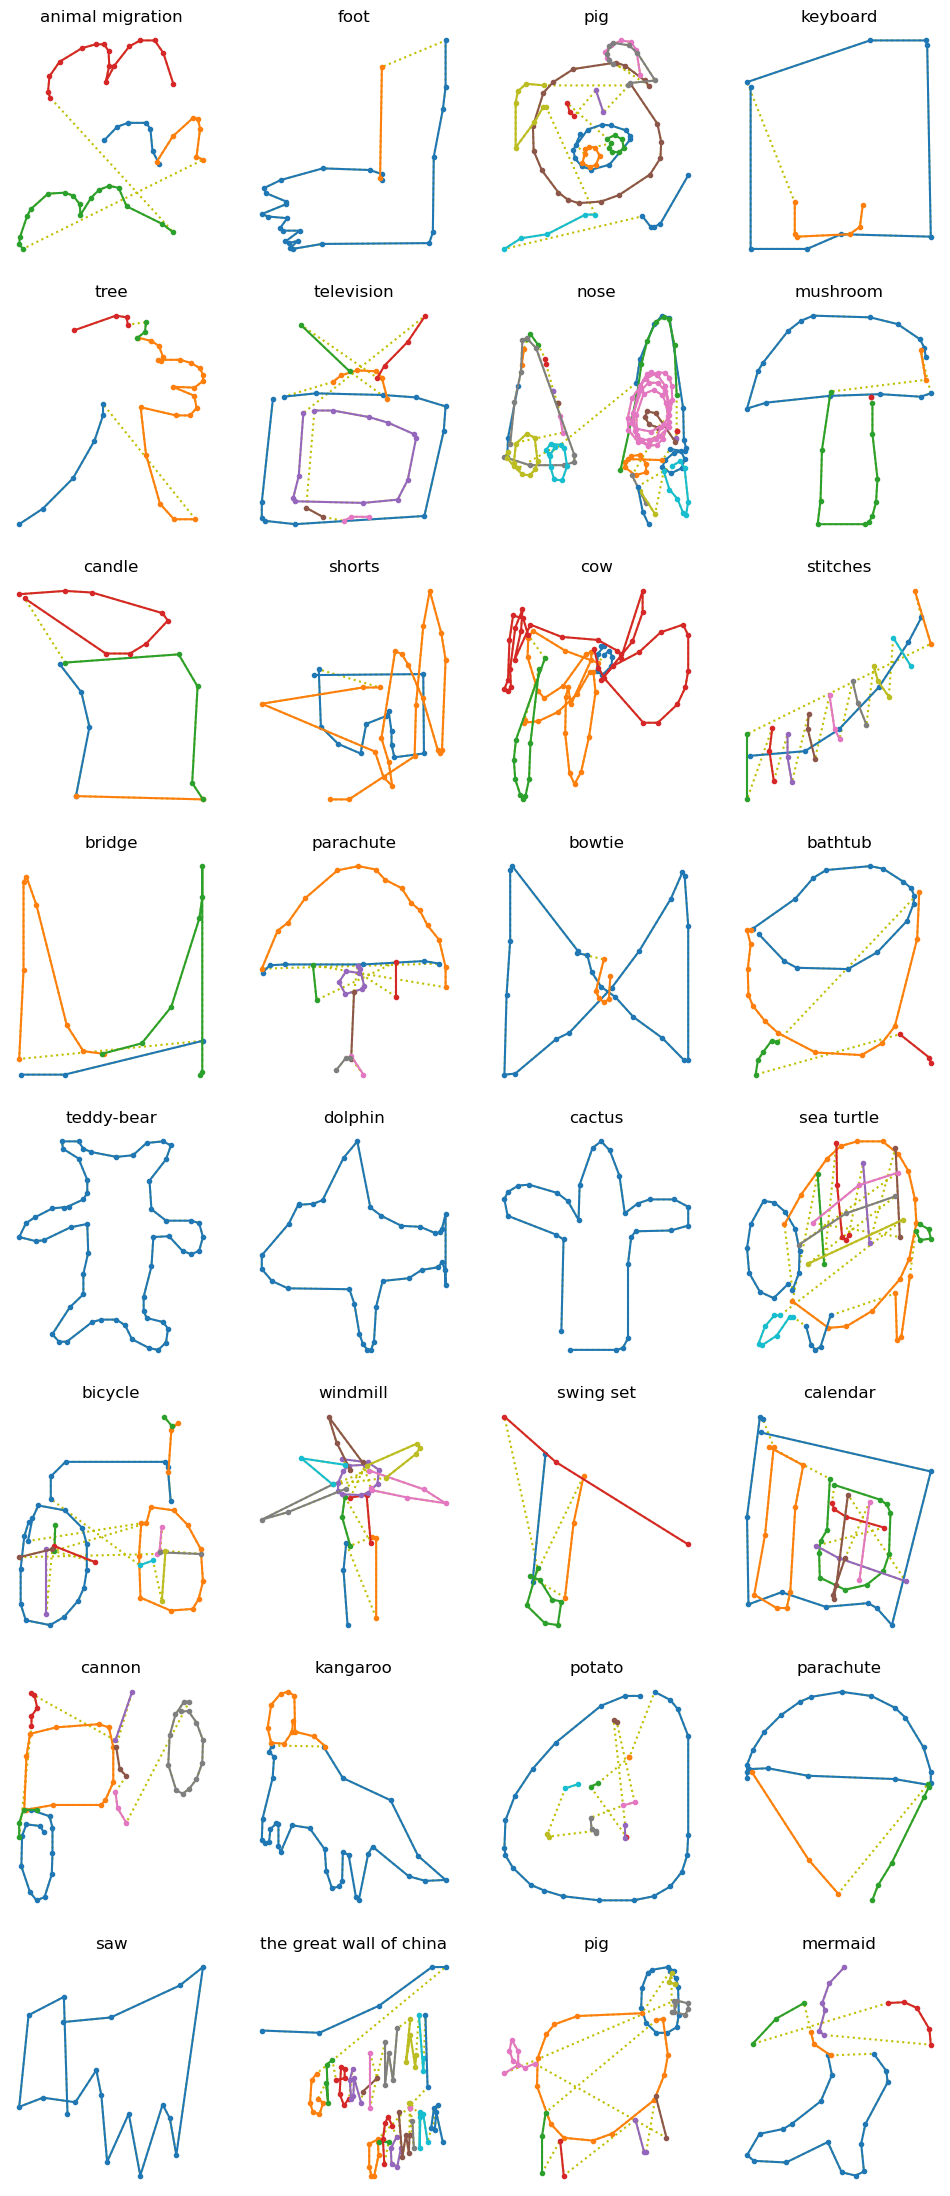

In [ ]:
import matplotlib.pyplot as plt

def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

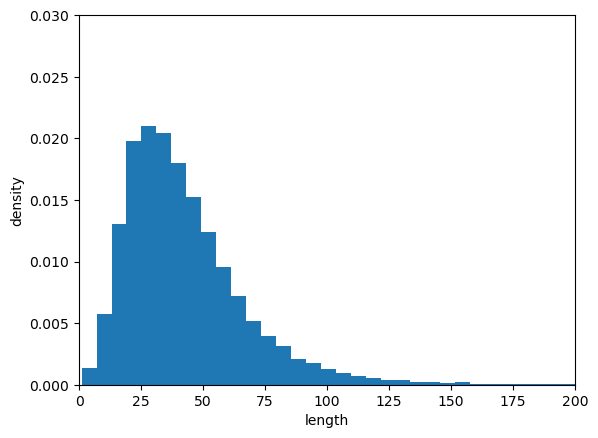

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show() 

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                   validation_data=cropped_valid_set)

Epoch 1/2
  35210/Unknown - 449s 12ms/step - loss: 5.1197 - accuracy: 0.0446 - sparse_top_k_categorical_accuracy: 0.1405

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn", save_format="tf")

## Bach Chorales

### Downloading the files

In [ ]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True
)

117793/117793 [==============================] - 0s 0us/step


'./datasets/jsb_chorales.tgz'

In [ ]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0][:5]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55]]

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)
            
n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Writing the music synthesizer

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]]
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together. It's much easier and simples to predict one note at a time. So we will need to preprocess every chorale, turning each chord into a sequence of notes rather than notes played simultaneously. So each chorale will be a long sequence of notes and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence apporach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

In [ ]:
n_notes

47

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, 
                    input_shape=[None]),
    layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    layers.BatchNormalization(),
    layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    layers.BatchNormalization(),
    layers.LSTM(256, return_sequences=True),
    layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          352       
                                                                 
 batch_normalization_7 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_8 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, None, 64)         

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 25s 62ms/step - loss: 1.8731 - accuracy: 0.5253 - val_loss: 3.7344 - val_accuracy: 0.0233
Epoch 2/20
98/98 [==============================] - 3s 29ms/step - loss: 0.8657 - accuracy: 0.7698 - val_loss: 3.7783 - val_accuracy: 0.0807
Epoch 3/20
98/98 [==============================] - 3s 32ms/step - loss: 0.7267 - accuracy: 0.7971 - val_loss: 3.4723 - val_accuracy: 0.1181
Epoch 4/20
98/98 [==============================] - 2s 24ms/step - loss: 0.6579 - accuracy: 0.8117 - val_loss: 2.9626 - val_accuracy: 0.1959
Epoch 5/20
98/98 [==============================] - 2s 24ms/step - loss: 0.6103 - accuracy: 0.8219 - val_loss: 2.0464 - val_accuracy: 0.3864
Epoch 6/20
98/98 [==============================] - 2s 22ms/step - loss: 0.5694 - accuracy: 0.8313 - val_loss: 1.0330 - val_accuracy: 0.6908
Epoch 7/20
98/98 [==============================] - 2s 25ms/step - loss: 0.5351 - accuracy: 0.8402 - val_loss: 0.7583 - val_accuracy: 0.7773
Epoch 8/20
9

In [ ]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

34/34 [==============================] - 1s 18ms/step - loss: 0.6651 - accuracy: 0.8154


[0.66507887840271, 0.8153916597366333]

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
        arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
        return tf.reshape(arpegio, shape=[-1, 4])

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")